In [1]:
# import dependencies

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

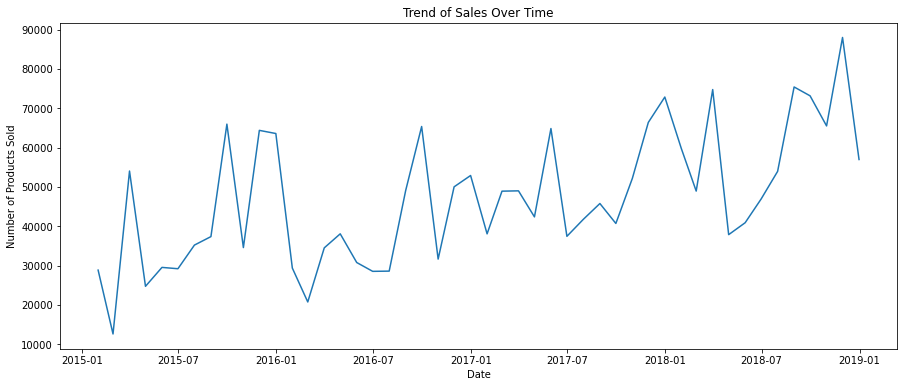

['Kentucky' 'California' 'Florida' 'North Carolina' 'Washington' 'Texas'
 'Wisconsin' 'Utah' 'Nebraska' 'Pennsylvania' 'Illinois' 'Minnesota'
 'Michigan' 'Delaware' 'Indiana' 'New York' 'Arizona' 'Virginia'
 'Tennessee' 'Alabama' 'South Carolina' 'Oregon' 'Colorado' 'Iowa' 'Ohio'
 'Missouri' 'Oklahoma' 'New Mexico' 'Louisiana' 'Connecticut' 'New Jersey'
 'Massachusetts' 'Georgia' 'Nevada' 'Rhode Island' 'Mississippi'
 'Arkansas' 'Montana' 'New Hampshire' 'Maryland' 'District of Columbia'
 'Kansas' 'Vermont' 'Maine' 'South Dakota' 'Idaho' 'North Dakota'
 'Wyoming' 'West Virginia']
      Row ID        Order ID Order Date   Ship Date       Ship Mode  \
9795    9796  CA-2017-125920 2017-05-21  28/05/2017  Standard Class   
9796    9797  CA-2016-128608 2016-12-01  17/01/2016  Standard Class   
9797    9798  CA-2016-128608 2016-12-01  17/01/2016  Standard Class   
9798    9799  CA-2016-128608 2016-12-01  17/01/2016  Standard Class   
9799    9800  CA-2016-128608 2016-12-01  17/01/2016  Stand

In [2]:
# read file

df = pd.read_csv('train.csv')

# Convert `date` to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales on a monthly basis
monthly_sales = df.resample('M', on='Order Date').sum()['Sales']

# Plot the trend of sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()


In [4]:

  print(df['Order Date'].tail())
print(df['Order Date'].head())

9795   2017-05-21
9796   2016-12-01
9797   2016-12-01
9798   2016-12-01
9799   2016-12-01
Name: Order Date, dtype: datetime64[ns]
0   2017-08-11
1   2017-08-11
2   2017-12-06
3   2016-11-10
4   2016-11-10
Name: Order Date, dtype: datetime64[ns]


In [8]:
# Statistical analysis for US Heatmap

# Group by 'State' and calculate the sum of sales for each state
state_sales_sum = df.groupby('State')['Sales'].sum().reset_index()

# Create a new DataFrame with only 'State' and 'Sales' columns
new_df = state_sales_sum[['State', 'Sales']]


# Calculate statistics
min_value = new_df['Sales'].min()
max_value = new_df['Sales'].max()
median_value = new_df['Sales'].median()
q25 = new_df['Sales'].quantile(0.25)
q75 = new_df['Sales'].quantile(0.75)
mode_value = new_df['Sales'].mode().iloc[0]

print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")
print(f"Median: {median_value}")
print(f"25% Percentile: {q25}")
print(f"75% Percentile: {q75}")

Minimum: 919.91
Maximum: 446306.4635
Median: 22205.15
25% Percentile: 7464.93
75% Percentile: 48219.11
Mode: 919.91


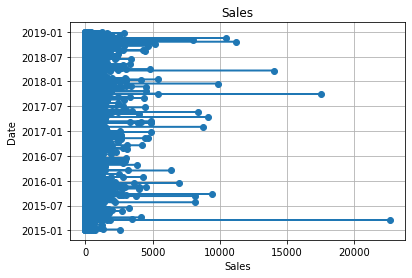

In [36]:
# Preprocessing
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df.sort_values(by='Order Date', inplace=True)
df.drop(columns=['Row ID'], inplace=True)
df.head()

plt.plot(df['Sales'], df['Order Date'], marker='o', linestyle='-')
plt.xlabel('Sales')
plt.ylabel('Date')
plt.title('Sales')
plt.grid(True)

plt.show()

In [4]:
# Checking columns for num of uniques 

print(f"Category : {df['Category'].nunique()}")
print(f"Region : {df['Region'].nunique()}")
print(f"Ship Mode : {df['Ship Mode'].nunique()}")
print(f"Sub-Category : {df['Sub-Category'].nunique()}")
print(f"Region : {df['Region'].nunique()}")
print(f"State: {df['State'].nunique()}")

Category : 3
Region : 4
Ship Mode : 4
Sub-Category : 17
Region : 4
State: 49


In [38]:
# Creating df for correlation exploration

corr_df = df.copy()

# Converting relevant categorical columns into numerical
from sklearn.preprocessing import LabelEncoder # Need to import this for the conversion of non-ordinal columns
label_encoder = LabelEncoder()

#The 3 columns we're going to be looking at for now is Category, Region and Sub-Category

corr_df['Region'] = label_encoder.fit_transform(corr_df['Region'])
corr_df['Category'] = label_encoder.fit_transform(corr_df['Category'])
corr_df['Sub-Category'] = label_encoder.fit_transform(corr_df['Sub-Category'])

print(corr_df['Category'].unique())
print(corr_df['Sub-Category'].unique())
print(corr_df['Region'].unique())


[1 2 0]
[12  3 14 10  2 13  5  8  9  0  7  4  1 16 15 11  6]
[0 1 2 3]


            Region     Category  Sub-Category         Sales
count  9800.000000  9800.000000   9800.000000   9800.000000
mean      1.571531     0.972959      7.589592    230.769059
std       1.162124     0.629563      5.052448    626.651875
min       0.000000     0.000000      0.000000      0.444000
25%       1.000000     1.000000      3.000000     17.248000
50%       1.000000     1.000000      9.000000     54.490000
75%       3.000000     1.000000     12.000000    210.605000
max       3.000000     2.000000     16.000000  22638.480000


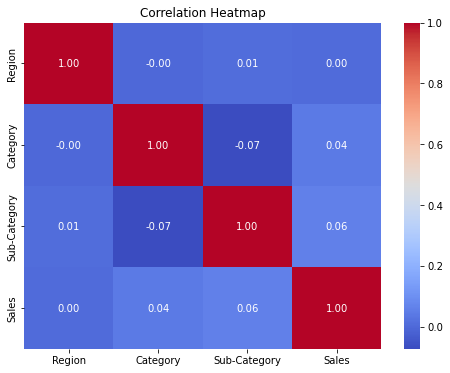

In [39]:
# Finding Correlations
data = corr_df[['Region', 'Category', 'Sub-Category', 'Sales']]
print(data.describe())

# Creating a heatmap

correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))  # Set the figure size
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Correlation Heatmap')
plt.show()

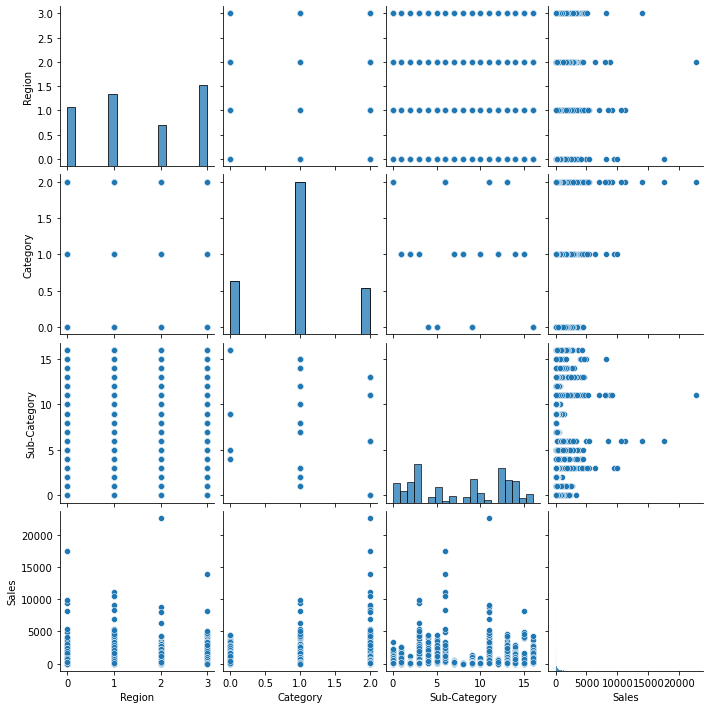

In [40]:
sns.pairplot(corr_df, vars=['Region', 'Category', 'Sub-Category', 'Sales'])
plt.show()

In [33]:
#The results shown are a bit hazy and do not really show any correlation.
#Lets group the rows by month to see if we can find any correlation on a large scale with less noise.

# Resampling
# monthly_sales = corr_df.resample('M', on='Order Date')['Sales'].sum().reset_index()
monthly_sales = df.resample('M', on='Order Date').sum()['Sales']

# Plot the trend of sales over time
plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Products Sold')
plt.show()

ValueError: cannot insert level_0, already exists

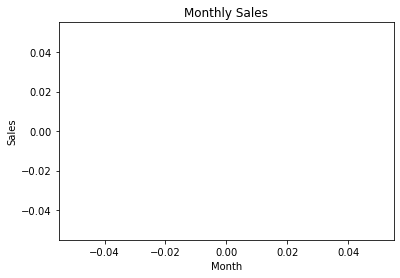